<h1>LSTM Stock Prediction Model</h1>

In this notebook we aim to construct a long short-term memory neural network (LSTM) to predict stock prices, this process may be applied to any stock.
We will proceed as follows
* Load and preprocess data - includes calculating various technical indicators and taking into account the overall market performance too
* Creating a preliminary model - this is a base model that we seek to optimize
* Tune the parameters - optimizing the base model
* Create the final model

<h2>Loading and Preprocessing Data</h2>

Importing the essentials

In [26]:
# The basics
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sna
import matplotlib.pyplot as plt
from datetime import date
from pylab import rcParams

# scikit-learn imports 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

# for model tuning 
from tqdm import tqdm_notebook

# for pretty pictures
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

We create two graphs using ploty in this notebook and the code below ensures they are nice enough to not just use matplotlib

In [27]:
# so we can see them
init_notebook_mode(connected=True)

# default background color 
layout = go.Layout(paper_bgcolor = 'rgba(0,0,0,0)', plot_bgcolor = 'rgba(250,250,250,0.3)')
fig = go.Figure(layout = layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In this notebook we will seek to predict Microsoft's stock price, however, one can change the .csv file for any stock. The .csv files are from Yahoo finance.

In [29]:
# loading
stock_df = pd.read_csv("AAPL.csv")
market_df = pd.read_csv("IXIC.csv")

In [30]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621428,14.732142,14.607142,14.686786,12.691425,302220800
1,2012-01-04,14.642858,14.810000,14.617143,14.765715,12.759631,260022000
2,2012-01-05,14.819643,14.948215,14.738214,14.929643,12.901293,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,13.036158,318292800
4,2012-01-09,15.196428,15.276786,15.048214,15.061786,13.015480,394024400


The following block contains various functions required for calculating various technical indicators.

In [31]:
# Relative strength index
def RSI(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

    
#Bollinger Bands (UpperBB & LowerBB)
def bbands(df, n=50):
    MA = df.Close.rolling(window=n).mean()
    SD = df.Close.rolling(window=n).std()
    return MA + (2 * SD), MA - (2 * SD)


# Force Index (ForceIndex)
def FI(df, n=1): 
    return df['Close'].diff(n) * df['Volume']

# Commodity Channel Index (CCI)
def CCI(df, n=20):
    TP = (df['High'] + df['Low'] + df['Close']) / 3 
    return (TP - TP.rolling(window=n).mean()) / (0.015 * TP.rolling(window=n).std())

# Ease Of Movement (EVM)
def EVM(df, n=14): 
    dm = ((df['High'] + df['Low'])/2) - ((df['High'].shift(1) + df['Low'].shift(1))/2)
    br = (df['Volume'] / 100000000) / ((df['High'] - df['Low']))
    EVM = dm / br 
    return EVM.rolling(window=n).mean()
    
# Rate of Change (ROC)
def ROC(df,n=5):
    N = df['Close'].diff(n)
    D = df['Close'].shift(n)
    return N/D

Below is the main preprocessing function that calculates various technical indicators 

In [32]:
def process_df(df,
               moving_average_windows = [5,10,15],
               market_df=None):
    
    # Date formatting
    df['Date'] = pd.to_datetime(df['Date'])
    market_df['Date'] = pd.to_datetime(market_df['Date'])
    
    # Technical Indicators
    
    # Relative strength index
    df['RSI'] = RSI(df).fillna(0)
    # Force index
    df['FI'] = FI(df)
    # Bollinger Bands
    df['UpperBB'],df['LowerBB'] = bbands(df)
    # Commodity Channel Index
    df['CCI'] = CCI(df)
    # Ease Of Movement
    df['EVM'] = EVM(df)
    # Rate of Change
    df['ROC'] = ROC(df)
    
    # Stochastic oscilator
    df['L14'] = df['Low'].rolling(window=14).min()
    df['H14'] = df['High'].rolling(window=14).max()
    # Oscilator value
    df['%K'] = 100*((df['Close'] - df['L14']) / (df['H14'] - df['L14']) )
    # 3 day rolling Stochastic oscilator
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    # Moving average calculations
    for i in moving_average_windows:
        df["EMA_"+str(i)] = df['Close'].ewm(i).mean().shift()
        df["SMA_"+str(i)] = df['Close'].rolling(i).mean().shift()
        
    # General information about stocks recent performance    
    df['Day%Change'] = df['Close'].pct_change()
    df['Week%Change'] = df['Close'].pct_change(periods=5)    
    
    # If market data is provided we can account for it here    
    if not (market_df.empty):
        df['MarketDay%Change'] = market_df['Close'].pct_change()
        df['MarketWeek%Change'] = market_df['Close'].pct_change(periods=5)
    
    # This will do more damage depending on the maximum moving average window
    df = df.dropna()
    
    return df

In [33]:
# Windows for calculating various moving averages
moving_average_windows = [5,10,15,20,50]

# Defining dataframe used to build model
df = process_df(stock_df,moving_average_windows,market_df)

In [34]:
# We will use these columns to predict the closing price on the next day
input_cols = ['Date','Open', 'High', 'Low', 'Adj Close', 'Volume', 'RSI',
       'FI', 'UpperBB', 'LowerBB', 'CCI', 'EVM', 'ROC', 'L14', 'H14', '%K',
       '%D', 'EMA_5', 'SMA_5', 'EMA_10', 'SMA_10', 'EMA_15', 'SMA_15',
       'EMA_20', 'SMA_20', 'EMA_50', 'SMA_50', 'Day%Change', 'Week%Change',
       'MarketDay%Change', 'MarketWeek%Change']

Now we take a look at our creation

In [35]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,FI,UpperBB,...,EMA_15,SMA_15,EMA_20,SMA_20,EMA_50,SMA_50,Day%Change,Week%Change,MarketDay%Change,MarketWeek%Change
50,2012-03-15,21.414642,21.428928,20.662500,20.912857,18.071619,1159718000,81.253073,-1.665030e+08,20.962171,...,18.582476,19.340500,18.293048,19.023036,17.642041,17.145414,-0.006818,0.080389,0.005144,0.028935
51,2012-03-16,20.882856,21.042856,20.642857,20.913214,18.071930,825487600,80.612113,2.946991e+05,21.153540,...,18.733752,19.505191,18.429100,19.179982,17.742918,17.269936,0.000017,0.074105,-0.000363,0.022394
52,2012-03-19,21.370358,21.491785,21.037500,21.467857,18.551216,901236000,81.712825,4.998642e+08,21.387968,...,18.874890,19.655572,18.557551,19.328839,17.839610,17.392886,0.026521,0.088949,0.007548,0.031726
53,2012-03-20,21.411072,21.674999,21.124287,21.641428,18.701204,816662000,81.321467,1.417488e+08,21.624874,...,19.042428,19.834953,18.707427,19.505589,17.949076,17.523650,0.008085,0.066643,-0.001355,0.011273
54,2012-03-21,21.526428,21.773214,21.478930,21.517857,18.594423,644042000,78.216464,-7.958491e+07,21.829019,...,19.210002,20.002929,18.857940,19.668286,18.059311,17.654764,-0.005710,0.021914,0.000381,0.011376


We can graph some of the moving averages along with the price.

In [36]:
fig = go.Figure()

for s in ['UpperBB','LowerBB','Close']:
    fig.add_trace(go.Scatter(x=df.Date, y=df[s], name=s))
for i in moving_average_windows:
    fig.add_trace(go.Scatter(x=df.Date, y=df["EMA_"+str(i)], name="EMA_"+str(i)))
    fig.add_trace(go.Scatter(x=df.Date, y=df["SMA_"+str(i)] , name="SMA_"+str(i)))    

fig.show()

The whole point of this notebook is to predict tomorrow's close to we shift the day column by one and we are ready to start building the mdoel

In [37]:
df['Close'] = df['Close'].shift(-1)
df = df.iloc[:-1] # accounts for shifting in close price
df = df.dropna()
df.index = range(len(df))

<ipython-input-37-5f5a9ac891a6>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<h2>Training, Validation and Testing Sets</h2>

We define the size (in percentage terms) of our validation and testing sets, for now we have 5% testing, 15% validation and 80% training.

In [38]:
test_size  = 0.05
validation_size = 0.15

test_index  = int(df.shape[0] * (1-test_size))
valid_index = int(df.shape[0] * (1-(validation_size+test_size)))

train_df  = df.loc[:valid_index].copy()
valid_df  = df.loc[valid_index+1:test_index].copy()
test_df   = df.loc[test_index+1:].copy()

# here is the second pretty graph using ploty
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

We initialize some parameters for the base model. These will be tuned later.

In [39]:
N = 10  # how many days our short term memory is                    
lstm_units = 50                  
dropout_prob = 0.5               
optimizer = 'adam'               
epochs = 1                       
batch_size = 1
model_seed = 100

First we define our training, validation and testing data sets

In [40]:
# The indexes
num_cv = int(validation_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

# Splitting the data sets using the indexes
train = df[:num_train]
cv = df[num_train:num_train+num_cv]

train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]

We define the following two functions to help with the training

In [41]:
def xy_split(X,y,N = 10, window = 10):
    Xs,ys = [],[]
    for i in range(window,len(X)):
        Xs.append(X[i-N:i])
        ys.append(y[i])
    return np.array(Xs),np.array(ys)

We are almost ready to train our base model, lastly we need to normalize the data. Note that we normalize the training data seperately to prevent information leak.

In [42]:
from sklearn.preprocessing import StandardScaler

# Train set

X_train = train[input_cols].drop(columns = ["Date"]).values
y_train = train["Close"].values.reshape(-1, 1)

X_scaler_train = StandardScaler()
X_train_scaled = X_scaler_train.fit_transform(X_train)

y_scaler_train = StandardScaler()
y_train_scaled = y_scaler_train.fit_transform(y_train)

X_train_scaled_0, y_train_scaled_0 = xy_split(X_train_scaled,y_train_scaled,N = N, window = N)

In [43]:
print(X_train_scaled_0.shape)
print(y_train_scaled_0.shape)

(1559, 10, 30)
(1559, 1)


In [44]:
# Validation set

X_valid = train_cv[input_cols].drop(columns = ["Date"]).values
y_valid = train_cv["Close"].values.reshape(-1, 1)

X_scaler_valid = StandardScaler()
X_valid_scaled = X_scaler_valid.fit_transform(X_valid)

y_scaler_valid = StandardScaler()
y_valid_scaled = y_scaler_valid.fit_transform(y_valid)

X_valid_scaled_0, y_valid_0 = xy_split(X_valid_scaled,y_valid,N = N, window = num_train)

In [45]:
print(X_valid_scaled_0.shape)
print(y_valid_0.shape)

(294, 10, 30)
(294, 1)


We define the following two functions for training

In [46]:
def calculate_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import math
def train_pred_eval_model(X_train_scaled, 
                          y_train_scaled, 
                          X_valid_scaled, 
                          y_valid, # note this is not scaled 
                          y_valid_scaler = None, # for using the inverse transform
                          N = 10,
                          lstm_units = 50, 
                          dropout_prob = 0.5, 
                          optimizer = 'adam', 
                          epochs = 1, 
                          batch_size = 1):
    
    # Create LSTM 
    model = Sequential()
    model.add(LSTM(units = lstm_units, 
                   return_sequences=True, 
                   input_shape = (X_train_scaled.shape[1],
                                  X_train_scaled.shape[2])))
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units = lstm_units))
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(1))

    # Compile LSTM 
    model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    
    # Fit LSTM
    model.fit(X_train_scaled, y_train_scaled, epochs = epochs, batch_size = batch_size, verbose = 0)
    
    # Do prediction
    predictions_scaled = model.predict(X_valid_scaled)
    predictions = y_valid_scaler.inverse_transform(predictions_scaled).reshape(-1,1)
    
    rmse = math.sqrt(mean_squared_error(y_valid, predictions))
    mape = calculate_mape(y_valid, predictions)
    
    return rmse, mape, predictions

<h3>Creating LSTM</h3>

Creating base model.

In [47]:
# Create
model = Sequential()
model.add(LSTM(units = lstm_units,
               return_sequences = True,
               input_shape = (X_train_scaled_0.shape[1],
                              X_train_scaled_0.shape[2])))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units = lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))

# Compile
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Fit
model.fit(X_train_scaled_0, y_train_scaled_0, epochs=epochs, batch_size=batch_size, verbose=2)

1559/1559 - 8s - loss: 0.2019


In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 50)            16200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 36,451
Trainable params: 36,451
Non-trainable params: 0
__________________________________________________

Predicting on validation set

In [49]:
# Prediction
pred_scaled = model.predict(X_valid_scaled_0)
# Applying the inverse transform to unscale data
pred = y_scaler_valid.inverse_transform(pred_scaled)

# RMSE
rmse_before_tuning = np.sqrt(mean_squared_error(y_valid_0, pred))
print("RMSE = %0.3f" % rmse_before_tuning)

# MAPE
mape_pct_before_tuning = calculate_mape(y_valid_0, pred)
print("MAPE = %0.3f%%" % mape_pct_before_tuning)

RMSE = 4.360
MAPE = 7.107%


Text(0, 0.5, 'Price')

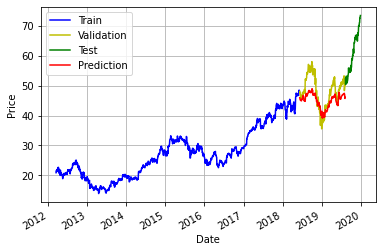

In [50]:
prediction_df = pd.DataFrame({'pred': pred.reshape(-1),
                              'y_cv': y_valid_0.reshape(-1),
                              'Date': cv['Date']})

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax = prediction_df.plot(x='Date', y='pred', style='r-', grid=True, ax=ax)

# Formatting
ax.legend(['Train', 'Validation', 'Test', 'Prediction'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")

This is our base model. Now the goal is to tune the parameters to make it more accurate.

<h2>Tuning Parameters</h2>

We have a few parameters we can tune
* N - how long our short term memory is
* Dropout probability & LSTM units
* Epochs & batch size
* The optimizer

<h3>Tuning N</h3>

In [51]:
# We seek to optimally pick N
param_label = 'N'

# Some candidates for N
param_list = range(4, 15)

# Defining a dictionary to track how good each N is
error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}

# it tells the time
import time
tic = time.time()

for param in tqdm_notebook(param_list):    
    print("Testing N="+str(param))
    
    
    # Splitting train according to N
    X_train_scaled_N, y_train_scaled_N = xy_split(X_train_scaled,y_train_scaled,N = param, window = param)

    # Splitting validation
    X_valid_scaled_N, y_valid_N = xy_split(X_valid_scaled, y_valid, N = param, window = num_train)    
    
         
    # Train, predict and eval model
    rmse_measure, mape_measure, _ = train_pred_eval_model(X_train_scaled_N,
                                                          y_train_scaled_N,
                                                          X_valid_scaled_N,
                                                          y_valid_N,
                                                          y_valid_scaler = y_scaler_valid,
                                                          N = param,
                                                          lstm_units = lstm_units,
                                                          dropout_prob = dropout_prob,
                                                          optimizer = optimizer,
                                                          epochs = epochs,
                                                          batch_size = batch_size)

    # Adding results of dictionary
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse_measure)
    error_rate['mape_pct'].append(mape_measure)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))


<ipython-input-51-95f3119fb509>:14: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


Testing N=4
Testing N=5
Testing N=6
Testing N=7
Testing N=8
Testing N=9
Testing N=10
Testing N=11
Testing N=12
Testing N=13
Testing N=14

Minutes taken = 1.8104750553766886


Text(0, 0.5, 'RMSE/MAPE(%)')

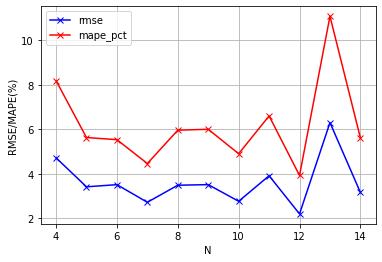

In [52]:
ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [53]:
x = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimal_N = x['N'].values[0]
print("optimum " + param_label + " = " + str(optimal_N))

optimum N = 12


<h3>Tuning Epochs & Batch Size</h3>

In [54]:
# We seek to optimize the following
param_label = 'epochs'
param2_label = 'batch_size'

# some candiates
param_list = [1, 10, 20, 30, 40, 50]
param2_list = [8, 16, 32, 64, 128]

# Splitting train
X_train_scaled_1, y_train_scaled_1 = xy_split(X_train_scaled,y_train_scaled,N = optimal_N, window = optimal_N)

# Splitting validation
X_valid_scaled_1, y_valid_1 = xy_split(X_valid_scaled,y_valid,N = optimal_N, window = num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in tqdm_notebook(param2_list):    
        
        rmse_measure, mape_measure, _ = train_pred_eval_model(X_train_scaled_1,
                                                              y_train_scaled_1,
                                                              X_valid_scaled_1,
                                                              y_valid_1,
                                                              y_valid_scaler = y_scaler_valid,
                                                              N = optimal_N,
                                                              lstm_units = lstm_units,
                                                              dropout_prob = dropout_prob,
                                                              optimizer = optimizer,
                                                              epochs = param,
                                                              batch_size = param2)
    
        # Saving results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_measure)
        error_rate['mape_pct'].append(mape_measure)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

<ipython-input-54-ad0447efdb48>:17: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-54-ad0447efdb48>:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-54-ad0447efdb48>:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-54-ad0447efdb48>:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-54-ad0447efdb48>:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-54-ad0447efdb48>:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-54-ad0447efdb48>:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.




Minutes taken = 11.44932957092921


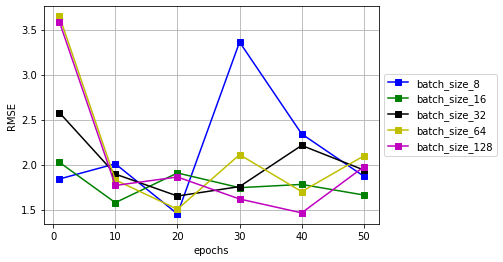

In [55]:
# Plot performance versus params

x = error_rate[error_rate[param2_label]==param2_list[0]]
ax = x.plot(x = param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    x = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = x.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [56]:
# Get optimum value for param and param2
x = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimal_epochs = x[param_label].values[0]
optimal_batch_size = x[param2_label].values[0]
#print("min RMSE = %0.3f" % error_rate['rmse'].min())
#print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimal_epochs))
print("optimum " + param2_label + " = " + str(optimal_batch_size))

optimum epochs = 20
optimum batch_size = 8


<h3>Tuning LSTM units & Dropout</h3>

In [57]:
# We seek to tune
param_label = 'lstm_units'
param2_label = 'dropout_prob'

# some candidates
param_list = [10, 50, 64, 128]
param2_list = [0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in tqdm_notebook(param2_list):
        
        rmse_measure, mape_measure, _ = train_pred_eval_model(X_train_scaled_1,
                                                              y_train_scaled_1,
                                                              X_valid_scaled_1,
                                                              y_valid_1,
                                                              y_valid_scaler = y_scaler_valid,
                                                              N = optimal_N,
                                                              lstm_units = param,
                                                              dropout_prob = param2,
                                                              optimizer = optimizer,
                                                              epochs = optimal_epochs,
                                                              batch_size = optimal_batch_size)
    
        # Record results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_measure)
        error_rate['mape_pct'].append(mape_measure)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

<ipython-input-57-4c0717f6bcd1>:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-57-4c0717f6bcd1>:12: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-57-4c0717f6bcd1>:12: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-57-4c0717f6bcd1>:12: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-57-4c0717f6bcd1>:12: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.




Minutes taken = 24.367282211780548


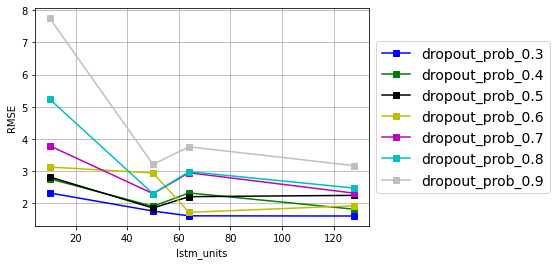

In [58]:
x = error_rate[error_rate[param2_label] == param2_list[0]]
ax = x.plot(x = param_label, y = 'rmse', style = 'bs-', grid = True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    y = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = y.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [60]:
# Get optimum value for param and param2
x = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimal_lstm_units = x[param_label].values[0]
optimal_dropout_prob = x[param2_label].values[0]
#print("min RMSE = %0.3f" % error_rate['rmse'].min())
#print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimal_lstm_units))
print("optimum " + param2_label + " = " + str(optimal_dropout_prob))

optimum lstm_units = 128
optimum dropout_prob = 0.3


<h2>Tuning the optimizer</h2>

In [61]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    rmse_measure, mape_measure, _ = train_pred_eval_model(X_train_scaled_1,
                                                          y_train_scaled_1,
                                                          X_valid_scaled_1,
                                                          y_valid_1,
                                                          y_valid_scaler = y_scaler_valid,
                                                          N = optimal_N,
                                                          lstm_units = optimal_lstm_units,
                                                          dropout_prob = optimal_dropout_prob,
                                                          optimizer = param,
                                                          epochs = optimal_epochs,
                                                          batch_size = optimal_batch_size)
   
    
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse_measure)
    error_rate['mape_pct'].append(mape_measure)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-61-a6ec08fae463>:6: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

Widget Javascript not detected.  It may not be installed or enabled properly.



Minutes taken = 14.67103079954783


,optimizer,rmse,mape_pct
0,adam,1.590473,2.508625
1,sgd,1.289245,2.100706
2,rmsprop,2.353580,4.236146
3,adagrad,1.659501,2.601383
4,adadelta,2.739545,4.607037
5,adamax,1.700199,2.738345
6,nadam,1.753332,2.742009


In [62]:
# Get optimum value for param and param2
x = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimal_optimizer = x[param_label].values[0]
print("optimum " + param_label + " = " + str(optimal_optimizer))

optimum optimizer = sgd


Tuned params

In [63]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_before_tuning, mape_pct_before_tuning],
     'after_tuning': [optimal_N, optimal_lstm_units, optimal_dropout_prob, 
                      optimal_optimizer, optimal_epochs, optimal_batch_size,
                      error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,10,12
1,lstm_units,50,128
2,dropout_prob,0.5,0.3
3,optimizer,adam,sgd
4,epochs,1,20
5,batch_size,1,8
6,rmse,4.35976,1.28924
7,mape_pct,7.10725,2.10071


In [92]:
# New training sets
X_valid = train_cv[input_cols].drop(columns = ["Date"]).values
y_valid = train_cv["Close"].values.reshape(-1, 1)

X_scaler_valid = StandardScaler()
X_valid_scaled = X_scaler_valid.fit_transform(X_valid)

y_scaler_valid = StandardScaler()
y_valid_scaled = y_scaler_valid.fit_transform(y_valid)

X_valid_scaled_final, y_valid_scaled_final = xy_split(X_valid_scaled,y_valid_scaled,N = optimal_N, window = optimal_N)

# Testing set 
X_test = df[input_cols].drop(columns = ["Date"]).values
y_test = df["Close"].values.reshape(-1, 1)

#y_test = y_test.iloc[num_train+num_cv:]

X_scaler_test = StandardScaler()
X_test_scaled = X_scaler_test.fit_transform(X_test)

y_scaler_test = StandardScaler()
y_test_scaled = y_scaler_test.fit_transform(y_test)

X_test_scaled_0, y_test_0 = xy_split(X_test_scaled,y_test,N = optimal_N, window = num_train+num_cv)

X_test = df[input_cols].drop(columns = ["Date"]).values


# Train, predict and eval model
rmse_measure, mape_measure, pred = train_pred_eval_model(X_valid_scaled_final,
                                                         y_valid_scaled_final,
                                                         X_test_scaled_0,
                                                         y_test_0,
                                                         y_valid_scaler = y_scaler_test,
                                                         N = optimal_N,
                                                         lstm_units = optimal_lstm_units,
                                                         dropout_prob = optimal_dropout_prob,
                                                         optimizer = optimal_optimizer,
                                                         epochs = optimal_epochs,
                                                         batch_size = optimal_batch_size)

RMSE on test set = 2.784
MAPE on test set = 3.257%
MSE on test set = 7.751%


In [97]:
# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse_measure)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape_measure)

RMSE on test set = 2.784
MAPE on test set = 3.257%


Text(0, 0.5, 'Price')

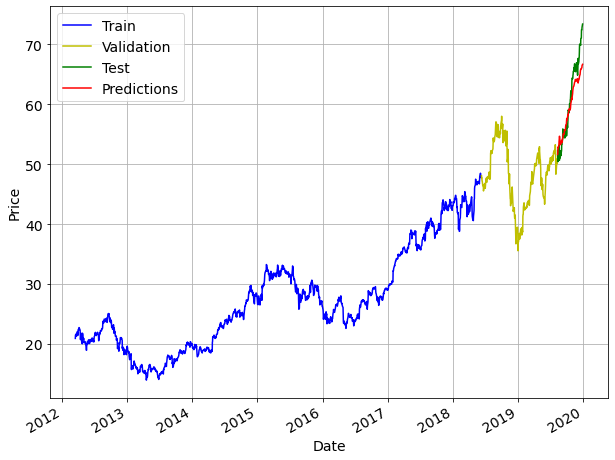

In [77]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

pred_df = pd.DataFrame({'est': pred.reshape(-1), 
                        'Date': df[num_train+num_cv:]['Date']})

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax = pred_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['Train', 'Validation', 'Test', 'Predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")

Text(0, 0.5, 'Price')

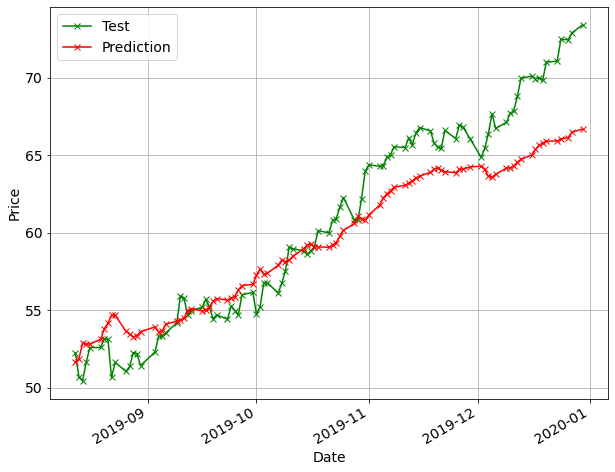

In [79]:
ax = test.plot(x='Date', y='Close', style='gx-', grid=True)
ax = pred_df.plot(x='Date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['Test', 'Prediction'], loc='upper left')
ax.set_xlabel("Date")
ax.set_ylabel("Price")

The model performs relatively well, follows the stock price effectively for approximately 4 months. It is worth noting that while the model seems to underestimate the prices in the last month that during this month the stock increased at a rate not seen before in the training data.